In [1]:
import torch
import numpy as np
from skimage import io
import os
from torch.utils.data import DataLoader
import torch.utils.data as data
from torchvision.transforms import transforms
import torch.optim as optim
from PIL import Image
import torchvision.datasets as dset
import torchvision
from torchvision import utils, models
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import tensorflow as tf
from torch.autograd import Variable
import argparse
from sklearn.metrics import accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#hyperparameters
num_classes=200
learning_rate=1e-3
batch_size=32
log_interval=10
num_epochs=1

train_dataset_path='/content/drive/MyDrive/Hw1/train/'
test_dataset_path='/content/drive/MyDrive/Hw1/test/'

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
target_model = models.resnet50(pretrained = True)


In [2]:
def default_loader(path):
    return Image.open(path).convert('RGB')

class myImageFloder(data.Dataset):
    def __init__(self, root, label, transform = None, target_transform=None, loader=default_loader):
        fh = open(label)
        c=0
        imgs=[]
        class_names=[]
        for line in  fh.readlines():
            #print(line)
            if c==0:
                class_names=[n.strip() for n in line.rstrip().split('	')]
                #print(class_names)
            else:
                cls = line.split() 
                fn = cls.pop(0)
                if os.path.isfile(os.path.join(root, fn)):
                    imgs.append((fn, tuple([float(v) for v in cls])))
            c=c+1
        self.root = root
        self.imgs = imgs
        self.classes = class_names
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = self.loader(os.path.join(self.root, fn))
        label=torch.LongTensor(label)
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.imgs)
    
    def getName(self):
        return self.classes

In [3]:
train_transform = transforms.Compose(
        [
        transforms.Resize((224,224)),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
    )
test_transform = transforms.Compose(
        [
        transforms.Resize((224,224)),  
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
    )
train_dataset=myImageFloder(root=train_dataset_path,label='/content/drive/MyDrive/Hw1/training_labels_change.txt', transform=train_transform)
test_dataset=myImageFloder(root=train_dataset_path,label='/content/drive/MyDrive/Hw1/testing_img_order_change.txt', transform=test_transform)

train_loader= torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32 , shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32 , shuffle=True)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


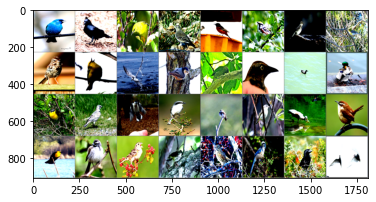

In [4]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(train_loader)
images, labels = dataiter.next()

# call function on our images
imshow(torchvision.utils.make_grid(images))
#print(images.shape)
#print(labels[0])

In [5]:
class CNN(nn.Module):
  def __init__(self):
        super(CNN, self).__init__()
        # Convolution 1 , input_shape=(3,224,224)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) #output_shape=(16,220,220) #(224-5+1)/1 #(weigh-kernel+1)/stride 無條件進位
        self.relu1 = nn.ReLU() # activation
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,110,110) #(220/2)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #output_shape=(32,106,106)
        self.relu2 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,53,53)
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=0) #output_shape=(16,51,51)
        self.relu3 = nn.ReLU() # activation
        # Max pool 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,25,25)
        # Convolution 4
        self.cnn4 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=0) #output_shape=(8,23,23)
        self.relu4 = nn.ReLU() # activation
        # Max pool 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) #output_shape=(8,11,11)
        # Fully connected 1 ,#input_shape=(8*12*12)
        self.fc1 = nn.Linear(8 * 11 * 11, 512) 
        self.relu5 = nn.ReLU() # activation
        self.fc2 = nn.Linear(512, 200) 
        
    
  def forward(self, x):
        
        out = self.cnn1(x) # Convolution 1
        out = self.relu1(out)
        out = self.maxpool1(out)# Max pool 1
        out = self.cnn2(out) # Convolution 2
        out = self.relu2(out) 
        out = self.maxpool2(out) # Max pool 2
        out = self.cnn3(out) # Convolution 3
        out = self.relu3(out)
        out = self.maxpool3(out) # Max pool 3
        out = self.cnn4(out) # Convolution 4
        out = self.relu4(out)
        out = self.maxpool4(out) # Max pool 4
        out = out.view(out.size(0), -1) # last CNN faltten con. Linear NN
        out = self.fc1(out) # Linear function (readout)
        out = self.fc2(out)
        
        return out
  
  

In [6]:
model = CNN()
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#from torchsummary import summary
#summary(model, (3, 224, 224))

def train(model,train_loader,optimizer,num_epochs):
    running_loss = 0.0
    running_corrrect = 0
    for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      running_corrrect = 0
      #for batch_idx, (data, target) in enumerate(train_loader):
      for batch_idx, (data, target) in enumerate(train_loader):
            inputs= data
            labels=target-1
            labels=labels.squeeze(1)
            #print(labels)
            #output = Variable(torch.randn(1, 200).float())
            #target = Variable(torch.FloatTensor(1).uniform_(0, 200).long())
            #inputs = Variable(torch.randn(1, 200).float())
            #labels = Variable(torch.FloatTensor(1).uniform_(0, 200).long())
            # Clear gradient
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(inputs)
            # compute the loss based on model output and real labels
            loss = criterion(outputs, labels)
            # Back propagation
            loss.backward()
            # Parameter update
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            running_loss += loss.item()
            running_corrrect += torch.sum(predicted == labels.data)
            #Acc=accuracy_score(inputs,data,predicted)

      print("Epoch  {}/{}".format(epoch+1, num_epochs))
      print("Loss is {:.4f}, Train Accuracy is:{:.4f}%".format(running_loss/len(train_dataset),100*running_corrrect/len(train_dataset)))



model.eval()
model=train(model, train_loader, optimizer, num_epochs)
PATH = '/content/drive/MyDrive/Hw1/CNN.pth'
torch.save(model, PATH)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch  1/1
Loss is 0.1653, Train Accuracy is:0.5002%


TypeError: ignored

In [ ]:
def test(model,test_loader,optimizer,num_epochs):
  # monitor test loss and accuracy
  test_loss = 0.
  correct = 0.
  total = 0.
  model.eval()
  submission = []
  with torch.no_grad():  
     for batch_idx, (data, target) in enumerate(test_loader):
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target.squeeze(1))
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        print('Test Loss: {:.6f}'.format(test_loss))

        print('Test Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))


test_model=test(model,test_loader,optimizer,num_epochs)
